# Phys763.HW4b-Detuning-ReturningQubits

This notebook analyzes single-qubit calibration data using QOLab/Qualibrate nodes. Datasets include both course-provided measurements and data personally acquired from running the nodes. The focus is on randomized benchmarking, detuning effects, and pulse retuning via Power Rabi and Ramsey experiments.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qm import SimulationConfig
from qm.qua import *
import os
import math
import xarray as xr
import pandas as pd
import json
from quam_libs.components import QuAM
from quam_libs.lib.save_utils import find_numbered_folder
from scipy.optimize import curve_fit
from qualang_tools.analysis.discriminator import two_state_discriminator
from quam_libs.lib.fit import fit_oscillation, oscillation
from quam_libs.lib.instrument_limits import instrument_limits

2025-12-30 16:42:28,987 - qm - INFO     - Starting session: 4f4fdeb7-940e-44e2-81db-c4a5d78834b7


/Users/chuma_navarro/Projects/qolab-start/.venv/lib/python3.12/site-packages/qm/results/__init__.py:15: DeprecationWarning: qm.results is deprecated since "1.2.3" and will be removed in "1.3.0". If you need anything from this module, import it directly from `qm` or from `qm.simulate` for simulator-related functionality.
  warnings.warn(


In [2]:
def load_dataset(serial_number, target_filename = "ds", parameters = None):
    """Load dataset by serial number."""
    if not isinstance(serial_number, int):
        raise ValueError("serial_number must be an integer")
    base_folder = find_numbered_folder("data",serial_number)
    nc_files = [f for f in os.listdir(base_folder) if f.endswith('.h5')]
    is_present = target_filename in [file.split('.')[0] for file in nc_files]
    filename = [file for file in nc_files if target_filename == file.split('.')[0]][0] if is_present else None
    json_filename = "data.json"
    if nc_files:
        file_path = os.path.join(base_folder, filename)
        json_path = os.path.join(base_folder, json_filename)
        ds = xr.open_dataset(file_path)
        with open(json_path, 'r') as f:
            json_data = json.load(f)
        try:
            machine = QuAM.load(base_folder + "/quam_state/state.json")
        except Exception as e:
            print(f"Error loading machine: {e}")
            machine = None
        qubits = [machine.qubits[qname] for qname in ds.qubit.values]
        if parameters is not None:
            for param_name, param_value in parameters:
                if param_name != "load_data_id" and param_name in json_data.get("initial_parameters", {}):
                    setattr(parameters, param_name, json_data["initial_parameters"][param_name])
            return ds, machine, json_data, qubits, parameters
        else:
            return ds, machine, json_data, qubits
    else:
        print(f"No .nc file found in folder: {base_folder}")
        return None

# 1. Get a token and activate it
You should have received a token. Within your properly setup environment, use
iqcc-cloud setup to enter your token. You should get a success message “Your
access token is setup successfully.” If you do not have a token, contact your token
group lead or me. Make sure you get the latest ‘wiring.json’ and ‘state.json’ files by
updating your git repo (‘git pull’).

Down below I attached an image showing that I activated the token and updated my git repo correctly.

![alt text](image.png)

# 2. RB Fitting
Extract the data from dataset 81 to plot randomized
benchmarking (RB) data. Fit the RB curves to extract error probabilities. Which
qubit has the best average error? Which has the best SPAM? Why?

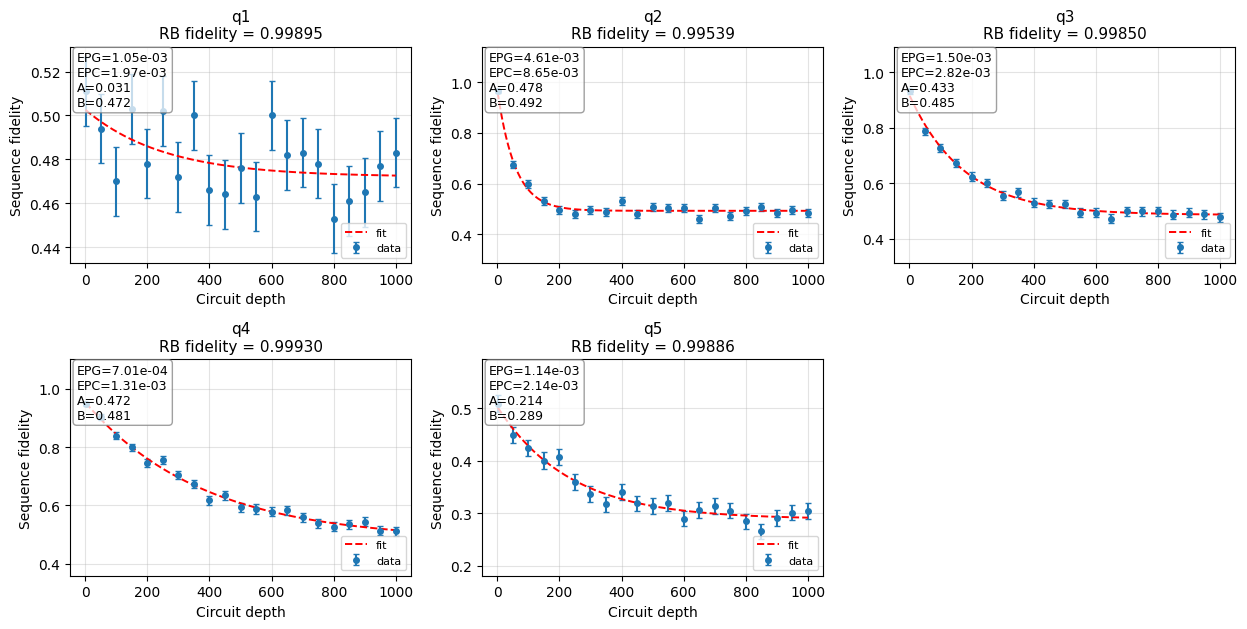

RB Fit Results (per qubit):
 qubit     A       p     B       EPC       EPG RB_fidelity
     1 0.031 0.99606 0.472 1.968e-03 1.049e-03     0.99895
     2 0.478 0.98270 0.492 8.651e-03 4.614e-03     0.99539
     3 0.433 0.99436 0.485 2.821e-03 1.505e-03     0.99850
     4 0.472 0.99737 0.481 1.314e-03 7.007e-04     0.99930
     5 0.214 0.99572 0.289 2.142e-03 1.142e-03     0.99886

Best (lowest) EPG / average error: q4
Best SPAM (highest B): q2
Note: Qolab RB fidelity = 1 - EPG, with EPG = EPC/1.875 and EPC=(1-p)/2.


In [3]:
# ---------------- Load dataset ----------------
b = load_dataset(81)
depths = b[0]["depths"].values.astype(int)
state  = b[0]["state"].values          # shape: (n_qubits, n_seeds, n_depths)
n_qubits = state.shape[0]

# ---------------- RB model ----------------
def rb_model(m, A, p, B):
    return A * (p ** m) + B

avg_gates_per_clifford = 1.875   # QOLab convention for 1Q RB

fit_results = []

# ---------------- Multi-panel layout ----------------
cols = 3 if n_qubits > 3 else n_qubits
rows = math.ceil(n_qubits / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4.2*cols, 3.2*rows), squeeze=False)

for qi in range(n_qubits):
    ax = axes[qi // cols][qi % cols]

    # Fidelity per seed, then mean over seeds
    F_seeds = 1 - state[qi]            # (n_seeds, n_depths)
    F_mean  = F_seeds.mean(axis=0)     # (n_depths,)
    F_sem   = F_seeds.std(axis=0, ddof=1) / np.sqrt(F_seeds.shape[0])

    # ---- Fit guesses ----
    A0 = max(F_mean[0] - F_mean[-1], 1e-4)
    B0 = F_mean[-1]
    p0 = 0.99

    try:
        popt, _ = curve_fit(rb_model, depths, F_mean, p0=[A0, p0, B0])
        A, p, B = popt
    except Exception as e:
        print(f"Fit failed for q{qi+1}: {e}")
        A, p, B = np.nan, np.nan, np.nan

    # ---- Extract errors (QOLab definitions) ----
    EPC = (1 - p)/2 if np.isfinite(p) else np.nan
    EPG = EPC / avg_gates_per_clifford if np.isfinite(EPC) else np.nan
    RB_fidelity_qolab = 1 - EPG if np.isfinite(EPG) else np.nan

    fit_results.append({
        "qubit": qi+1, "A": A, "p": p, "B": B,
        "EPC": EPC, "EPG": EPG, "RB_fidelity": RB_fidelity_qolab
    })

    # ---- Plot data + fit ----
    ax.errorbar(depths, F_mean, yerr=F_sem, fmt='o', ms=4, capsize=2,
                color='#1f77b4', label='data')

    if np.isfinite(p):
        m_smooth = np.linspace(depths.min(), depths.max(), 300)
        ax.plot(m_smooth, rb_model(m_smooth, A, p, B),
                '--', color='red', lw=1.4, label='fit')

    # Titles and labels
    ax.set_title(f"q{qi+1}\nRB fidelity = {RB_fidelity_qolab:.5f}", fontsize=11)
    ax.set_xlabel("Circuit depth")
    ax.set_ylabel("Sequence fidelity")
    ax.grid(alpha=0.35)

    # Dynamic y-limits
    fmin, fmax = F_mean.min(), F_mean.max()
    span = max(fmax - fmin, 0.02)
    pad = 0.35 * span
    ax.set_ylim(fmin - pad, fmax + pad)

    # Text box
    if np.isfinite(p):
        ax.text(
            0.02, 0.98,
            f"EPG={EPG:.2e}\nEPC={EPC:.2e}\nA={A:.3f}\nB={B:.3f}",
            transform=ax.transAxes,
            ha='left', va='top', fontsize=9,
            bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.75)
        )

    ax.legend(fontsize=8, loc="lower right")

# Hide unused panels
for i in range(n_qubits, rows*cols):
    axes[i // cols][i % cols].axis('off')

plt.tight_layout()
plt.show()

# ---------------- Summary / ranking ----------------
df = pd.DataFrame(fit_results)

best_qubit = int(df.sort_values("EPG").iloc[0].qubit)          # best average error
best_spam_qubit = int(df.sort_values("B", ascending=False).iloc[0].qubit)

print("RB Fit Results (per qubit):")
print(df[["qubit","A","p","B","EPC","EPG","RB_fidelity"]].to_string(
    index=False,
    formatters={
        "A": lambda v: f"{v:.3f}",
        "p": lambda v: f"{v:.5f}",
        "B": lambda v: f"{v:.3f}",
        "EPC": lambda v: f"{v:.3e}",
        "EPG": lambda v: f"{v:.3e}",
        "RB_fidelity": lambda v: f"{v:.5f}",
    }
))

print(f"\nBest (lowest) EPG / average error: q{best_qubit}")
print(f"Best SPAM (highest B): q{best_spam_qubit}")
print("Note: Qolab RB fidelity = 1 - EPG, with EPG = EPC/1.875 and EPC=(1-p)/2.")


## Answers:

Thanks to the information extracted from the experiment files and graphs, it is possible to identify that the qubit with the best average error (error per gate) is qubit 4, with an average error of approximately 0.07%.  This means that q4 has the most accurate gates and the slowest decay of the RB curve.                                                                     
On the other hand, the qubit with the best SPAM (State Preparation And Measurement) is qubit 2, because it has a value of B ≈ 0.492, which corresponds to the offset when the curve is saturated, and is the value of B that is closest to the ideal value of ≈ 0.500 since the fidelity saturates 1/2. This tell us that qubit 2 has a better state preparation, discrimination, and readout fidelity than the other qubits. But it is also important to notice that qubit 2 has the fastest decay rate from all qubits.                            
Once the results have been exposed, I consider it important to clarify what each parameter measures and means. The parameters p, EPG (Error per Gate), and EPC (Error per Clifford) are related to gate errors measurement because they determine how fast fidelity decays in the circuit depth. Meanwhile, parameters A, which affects initial fidelity, and B, which corresponds to the final offset and the saturation value of the fidelity, capture SPAM errors because they affect initial fidelity and final offset, but not decay.                                                                                               
So, that is why qubit 2 has the best SPAM fidelity, but qubit 4 has the best gate fidelity.


# 3. Detuned Qubit
Extract the data from dataset 110 and use your
code from problem 2 to extract the average error. Note this is only on qubit 4.
Compare it the results of problem 2. How much worse is the qubit? Compare the
state.json files in the quam state folder for dataset 81 and dataset 110. What
variable has changed? What is the purpose of this variable? What effect would it
have on the qubit?

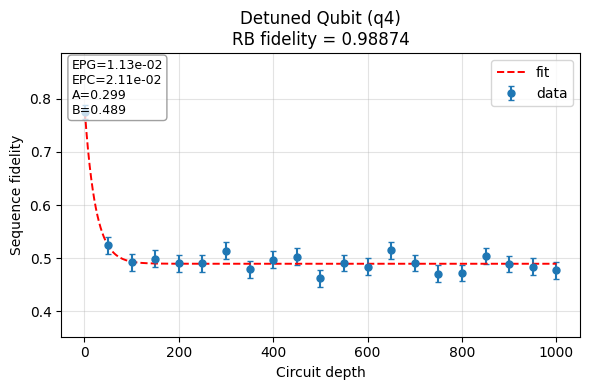

Detuned Qubit RB Fit:
A   = 0.29918
p   = 0.95777
B   = 0.48944
EPC = 2.111e-02
EPG = 1.126e-02
RB fidelity (Qolab) = 0.98874


In [4]:
# ---------------- Load dataset 110 ----------------
a = load_dataset(110)
depths = a[0]["depths"].values.astype(int)

# Dataset 110 is only for qubit 4 → index 0
state = a[0]["state"].values  # shape: (1, n_seeds, n_depths)

# ---------------- RB model ----------------
def rb_model(m, A, p, B):
    return A * (p ** m) + B

avg_gates_per_clifford = 1.875   # QOLab 1-qubit RB convention

# ---------------- Extract fidelity data ----------------
F_seeds = 1 - state[0]          # (n_seeds, n_depths)
F_mean  = F_seeds.mean(axis=0)
F_sem   = F_seeds.std(axis=0, ddof=1) / np.sqrt(F_seeds.shape[0])

# ---------------- Fit initial guesses ----------------
A0 = max(F_mean[0] - F_mean[-1], 1e-4)
B0 = F_mean[-1]
p0 = 0.99

try:
    popt, _ = curve_fit(rb_model, depths, F_mean, p0=[A0, p0, B0])
    A, p, B = popt
except Exception as e:
    print("Fit failed:", e)
    A, p, B = np.nan, np.nan, np.nan

# ---------------- Compute EPC, EPG, RB fidelity ----------------
EPC = (1 - p) / 2
EPG = EPC / avg_gates_per_clifford
RB_fidelity_qolab = 1 - EPG

# ---------------- Plot ----------------
plt.figure(figsize=(6,4))

plt.errorbar(depths, F_mean, yerr=F_sem, fmt='o', ms=5, capsize=2,
             color='#1f77b4', label='data')

m_smooth = np.linspace(depths.min(), depths.max(), 300)
plt.plot(m_smooth, rb_model(m_smooth, A, p, B), '--', lw=1.4, color='red', label='fit')

plt.title(f"Detuned Qubit (q4)\nRB fidelity = {RB_fidelity_qolab:.5f}", fontsize=12)
plt.xlabel("Circuit depth")
plt.ylabel("Sequence fidelity")
plt.grid(alpha=0.35)

# Smart y-limits
fmin, fmax = F_mean.min(), F_mean.max()
pad = 0.35 * max(fmax - fmin, 0.02)
plt.ylim(fmin - pad, fmax + pad)

# Text box with parameters
plt.text(
    0.02, 0.98,
    f"EPG={EPG:.2e}\nEPC={EPC:.2e}\nA={A:.3f}\nB={B:.3f}",
    transform=plt.gca().transAxes,
    ha='left', va='top',
    fontsize=9,
    bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.75)
)

plt.legend()
plt.tight_layout()
plt.show()

# ---------------- Print results ----------------
print("Detuned Qubit RB Fit:")
print(f"A   = {A:.5f}")
print(f"p   = {p:.5f}")
print(f"B   = {B:.5f}")
print(f"EPC = {EPC:.3e}")
print(f"EPG = {EPG:.3e}")
print(f"RB fidelity (Qolab) = {RB_fidelity_qolab:.5f}")


## Answers:
First, just by comparing the graphs corresponding to qubit 4 in experiments #81 and #110  it can be seen right away that in experiment #110 the qubit fidelity ≈ 0.98874 is lower than in experiment #81 with fidelity ≈ 0.99930, which means that the qubit decay rate increased between experiments, and if we compute the error ratio between experiments (1.126e-2)/(7.007e-04) ≈ 16 we realized that the qubit on the experiment #110 is around 16 times worse than in experiment #81. Also, by observing the rest of the parameters, we can notice that all parameters worsened except for parameter B, which became closer to the ideal value of ≈ 0.500.                                                                                                                                         
Now, after comparing the .json files side by side, it is possible to determine that the variable that changed within the calibration of qubit 4 is the pulse amplitude corresponding to the x180_DragCosine operation, since in experiment #81 an amplitude of ≈ 0.08632 was recorded, while in experiment #110 the amplitude was ≈ 0.19632, representing an increase of approximately 127% in this variable.                                                                       
It is important to consider that the pulse amplitude controls the Rabi rate and, consequently, the rotation angle, which should be exactly 180 degrees (π-pulse). Therefore, if the amplitude increases but the length is not recalibrated according to this change, then an over-rotation error occurs, which causes each Clifford to be less accurate, resulting in faster RB decay and that is what causes the qubit to be around 16 times worse in experiment #110 than in experiment #81.

# 4. Retuning Qubit 4

Unfortunately, I answered this question using the "Relevant Datasets" since the qubits seem to be down.

## Part (a) 
First, compare the state.json file for dataset 110 (found in data/2025-11-
13/#110 10a Single Qubit Randomized Benchmarking 043752/quam state) to the
state.json in your qolab-start config/quam state folder. Note that config/quam -
state/state.json is what is used to actually run experiments. By editing the file
directly, change the single variable identified in problem 3 to the value from dataset
110. This should intentionally ‘detune’ the qubit. In the ‘Node Library’ tab, run node
10a Single Qubit Randomized Benchmarking for only qubit 4 (by entering ‘q4’ in
the qubits box and clicking ‘Run’). What is resulting error? Is this better or worse
than the average error seen in problem 2 and in problem 3? Dataset 110 may be
useful as reference.

### Answer (a):
The variable identified in problem 3 is the amplitude of the x180_DragCosine operation (π-pulse), which we find to have a value of Amplitude ≈ 0.19632, so that is the parameter that we are suppose to change in the current state.json file. Now, below is a plot of the output I obtained after running the node, which confirms that qubits are down for the moment.

![alt text](image-1.png)

Anyways, comparing both .json files from dataset #110 and the current state, it can be noticed that the only changed variable is the amplitude of the x180_DragCosine operation, and in fact, the current state.json file is equal to the one that corresponds to dataset #81, that allows us to answer the questions for part a).                                
By changing the amplitude variable in the current state.json file and running the node 10a it would give us the same error per gate (EPG) as in problem 3 for dataset #110. Thus, we could expect the resulting error to be = 1.126e-02 = 1.126%, which is the same average error than in problem 3 for obvious reasons, and compared to problem 2 (dataset #81) we already know that the EPG for our currect state.json would be approximately 16 times worse than in problem 2.

### Update (a) (Qubits are back):


Now that qubits are back and working, I ran the experiment (dataset #118) after changing the amplitude variable in the state.json. The plot of this experiment confirms the hypothesis that by changing the amplitude variable for the x180_DragCosine operation for the "detuned" value it affects and decreases the fidelity. In this case we can actually see that the average error per gate of dataset #118 is sligthly higher than dataset #81 (problem 2) and dataset #110 (problem 3).

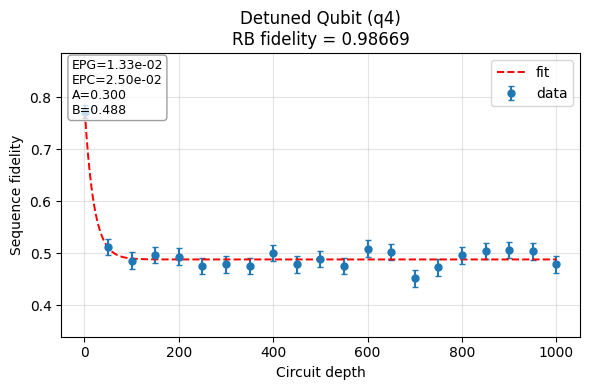

Detuned Qubit RB Fit:
A   = 0.29963
p   = 0.95010
B   = 0.48834
EPC = 2.495e-02
EPG = 1.331e-02
RB fidelity (Qolab) = 0.98669


In [5]:
# ---------------- Load dataset 118 ----------------
a = load_dataset(118)
depths = a[0]["depths"].values.astype(int)

# Dataset 118 is only for qubit 4 → index 0
state = a[0]["state"].values  # shape: (1, n_seeds, n_depths)

# ---------------- RB model ----------------
def rb_model(m, A, p, B):
    return A * (p ** m) + B

avg_gates_per_clifford = 1.875   # QOLab 1-qubit RB convention

# ---------------- Extract fidelity data ----------------
F_seeds = 1 - state[0]          # (n_seeds, n_depths)
F_mean  = F_seeds.mean(axis=0)
F_sem   = F_seeds.std(axis=0, ddof=1) / np.sqrt(F_seeds.shape[0])

# ---------------- Fit initial guesses ----------------
A0 = max(F_mean[0] - F_mean[-1], 1e-4)
B0 = F_mean[-1]
p0 = 0.99

try:
    popt, _ = curve_fit(rb_model, depths, F_mean, p0=[A0, p0, B0])
    A, p, B = popt
except Exception as e:
    print("Fit failed:", e)
    A, p, B = np.nan, np.nan, np.nan

# ---------------- Compute EPC, EPG, RB fidelity ----------------
EPC = (1 - p) / 2
EPG = EPC / avg_gates_per_clifford
RB_fidelity_qolab = 1 - EPG

# ---------------- Plot ----------------
plt.figure(figsize=(6,4))

plt.errorbar(depths, F_mean, yerr=F_sem, fmt='o', ms=5, capsize=2,
             color='#1f77b4', label='data')

m_smooth = np.linspace(depths.min(), depths.max(), 300)
plt.plot(m_smooth, rb_model(m_smooth, A, p, B), '--', lw=1.4, color='red', label='fit')

plt.title(f"Detuned Qubit (q4)\nRB fidelity = {RB_fidelity_qolab:.5f}", fontsize=12)
plt.xlabel("Circuit depth")
plt.ylabel("Sequence fidelity")
plt.grid(alpha=0.35)

# Smart y-limits
fmin, fmax = F_mean.min(), F_mean.max()
pad = 0.35 * max(fmax - fmin, 0.02)
plt.ylim(fmin - pad, fmax + pad)

# Text box with parameters
plt.text(
    0.02, 0.98,
    f"EPG={EPG:.2e}\nEPC={EPC:.2e}\nA={A:.3f}\nB={B:.3f}",
    transform=plt.gca().transAxes,
    ha='left', va='top',
    fontsize=9,
    bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.75)
)

plt.legend()
plt.tight_layout()
plt.show()

# ---------------- Print results ----------------
print("Detuned Qubit RB Fit:")
print(f"A   = {A:.5f}")
print(f"p   = {p:.5f}")
print(f"B   = {B:.5f}")
print(f"EPC = {EPC:.3e}")
print(f"EPG = {EPG:.3e}")
print(f"RB fidelity (Qolab) = {RB_fidelity_qolab:.5f}")


## Part (b) 
As it turns out, ‘Power Rabi’ is the experiment that tunes up this parameter.
Using the ‘Data’ tab of Qualibrate, look at experiment 101, which is ‘Power Rabi’ for
a tuned-up qubit 4. What is ‘Power Rabi’ doing? What is it sensitive to, and why is
that related to the variable identified in problem 3? It may be helpful to look at the
code for Power Rabi (code/calibration graph/04 Power Rabi.py).

### Answer (b):
After reviewing the files in dataset #101 and the source code for node 04_Power_Rabi, it is possible to see that this node is designed to calibrate the amplitude of the control pulse (by default, this is the π-pulse or x180 operation). What this node does is sweep a multiplicative amplitude factor around the current value stored in the state.json file, and for each amplitude it executes one or more Rabi pulses and measures the state of the qubit. This produces a Rabi-type oscillation as a function of amplitude. Basically, the code adjusts the oscillation and extracts a correction factor for the amplitude of π.                                                                               
Now, what is it sensitive to? The power rabi node is mainly sensitive to the amplitude calibration of the XY axis, because if the actual amplitude is different from the nominal amplitude, then the rotation angle is different from the desired angle. Therefore, when the Rabi curve is traversed, the adjustment detects that movement and suggests a new value to correct the shift.                                                                                             
That said, it is easy to see that the variable identified in problem 3 is precisely the variable that the Power rabi is responsible for calibrating. By sweeping amplitude and adjusting the oscillation, it returns the correct amplitude value so that the x180 operation is actually a π-pulse.

## Part (c)
In the ‘Node Library’ tab, run node 04 Power Rabi for only qubit 4 (by en-
tering ‘q4’ in the qubits box and clicking ‘Run’). Compare the results to the ‘Power
Rabi’ of dataset 101. What is the difference with respect to dataset 101? Qualibrate
will automatically suggest a change for the qubit in a pop-up box. That value is in
the fit results json file and can be seen in the ‘Data’ tab’s view of the data, as well. Is
the value significantly different? Why? What is Power Rabi doing to get that value?
Dataset 108 may be useful as reference.

### Answer (C):
For this part, since the qubits are down and we cannot obtain new information from the experiments, I will use dataset #108 as a reference from the beginning to compare with the results of dataset #101.
Looking at the results of experiment #108 (detuned qubit), the value suggested by Qualibrate for the amplitude of the π-pulse is 0.0884710, and we can see that in dataset #101 (qubit tuned correctly) the value of the amplitude of the π-pulse is 0.0883246.                                                                                                   
Comparing the value suggested by the node in dataset #108 and the current value in dataset #101, we can see that the difference between the two values is very small, approximately 0.17%, so the value suggested in dataset #108 is returning the current value used in dataset #101, confirming that the qubit was tuned correctly in dataset #101.      
Now I will explain what the Power rabi node does to obtain the correct suggested value for the amplitude of the π-pulse. First, it sweeps the amplitude using amps = arange(min_amp_factor, max_amp_factor, step) as a prefactor of the current value stored in state.json. It then compares the amplitude with the measurement of the Rabi oscillations of the excited population. Next, it adjusts the oscillations obtained using fit_oscillation() to find the frequency f and phase ϕ. With these values, it finds a correlation factor = (π - ϕ)/2πf. Finally, it multiplies the factor found by the current amplitude to find the corrected new amplitude for the π-pulse. In other words, it uses the period and phase of the oscillation to determine the amplitude at which the pulse produces exactly π.


### Update (c):
Now, having the opportunity of running experiments, I collected the dataset #119, which corresponds to a Power Rabi node with the "detuned" state of the qubit, and we can observe that the suggested value for the amplitude of the x180_DragCosine operation by the node is 0.085815237850235 V, which is close to the value used in the dataset #108. Down below you can observe the plot for the dataset #119.

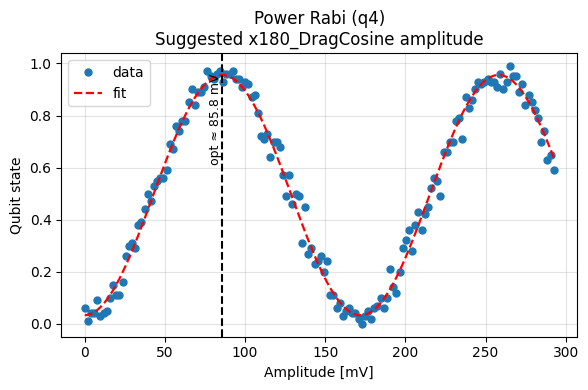

New suggested x180_DragCosine amplitude:
0.085815237850235 V


In [6]:
# ---------------- Load dataset ----------------
a = load_dataset(119)

amps = a[0]["amp"].values
abs_amp = a[0]["abs_amp"].values

# Prefer state if available
if "state" in a[0].variables:
    y = a[0]["state"].values
    state_discrimination = True
else:
    y = a[0]["I"].values
    state_discrimination = False

# q4 only (dataset 110 has only q4 at index 0)
if y.ndim == 3:
    y_q4 = y[0].mean(axis=0)
else:
    y_q4 = y[0]

amp_mV_q4 = abs_amp[0] * 1e3

# ---- Build minimal dataset for node-like fit ----
import xarray as xr

ds_q4 = xr.Dataset(
    data_vars=dict(
        trace=(["qubit","amp"], np.expand_dims(y_q4, axis=0))
    ),
    coords=dict(
        qubit=["q4"],
        amp=amps,
        abs_amp=(["qubit","amp"], np.expand_dims(abs_amp[0], axis=0))
    )
)

fit = fit_oscillation(ds_q4.trace, "amp")
fit_eval = oscillation(
    ds_q4.amp,
    fit.sel(fit_vals="a"),
    fit.sel(fit_vals="f"),
    fit.sel(fit_vals="phi"),
    fit.sel(fit_vals="offset"),
).loc["q4"].values


# ------------- Correct SUGGESTED amplitude (x180_DragCosine) -------------
q4_obj = [q for q in a[3] if getattr(q, "name", "") == "q4"][0]

operation = "x180_DragCosine"   # <-- THIS is the important correction

old_amp = q4_obj.xy.operations[operation].amplitude

f_fit   = float(fit.loc["q4"].sel(fit_vals="f"))
phi_fit = float(fit.loc["q4"].sel(fit_vals="phi"))
phi_fit = phi_fit - np.pi * (phi_fit > np.pi/2)
factor = float((np.pi - phi_fit) / (2*np.pi*f_fit))

new_pi_amp = old_amp * factor

limits = instrument_limits(q4_obj.xy)
if new_pi_amp > limits.max_x180_wf_amplitude:
    new_pi_amp = limits.max_x180_wf_amplitude

suggested_amp_mV = new_pi_amp * 1e3


# ---------------- Plot ----------------
plt.figure(figsize=(6,4))

plt.plot(amp_mV_q4, y_q4, 'o', ms=5, label='data')
plt.plot(amp_mV_q4, fit_eval if state_discrimination else 1e3*fit_eval,
         '--', lw=1.6, color='red', label='fit')

plt.axvline(suggested_amp_mV, ls='--', lw=1.5, color='k')
plt.text(
    suggested_amp_mV, 0.97*np.max(y_q4),
    f"opt ≈ {suggested_amp_mV:.1f} mV",
    rotation=90, va='top', ha='right', fontsize=9
)

plt.title("Power Rabi (q4)\nSuggested x180_DragCosine amplitude", fontsize=12)
plt.xlabel("Amplitude [mV]")
plt.ylabel("Qubit state" if state_discrimination else "Trans. amp. I [mV]")
plt.grid(alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()


# ---------------- Print only the suggested value ----------------
print('New suggested x180_DragCosine amplitude:')
print(f"{new_pi_amp:.15f} V")


## Part (d) 
Take the Power Rabi suggested value and change config/quam state/state.json
to have that value (manual editing of the file may be necessary). Note that the ‘Ac-
cept All’ and checkmarks, which I guess are intended to automatically change the
config/quam state/state.json do not seem to work for me. Run node 10a Sin-
gle Qubit Randomized Benchmarking for only qubit 4 (by entering ‘q4’ in the qubits
box and clicking ‘Run’). What is resulting error? Is this better or worse than the
average error seen from the intentionally detuned RB from part (a)? Why? Dataset
112 may be useful as reference.

### Answer (d):
For this part, I would have to modify the state.json file with the new value suggested by dataset #108 (from fit_results) for the amplitude of the π-pulse = 0.0884710. On this occasion, due to the failure of the qubits, I will use dataset #112 as a reference. Dataset #112 shows that after accepting the recalibrated amplitude, the RB of q4 recovers a high fidelity ≈ 0.99827 (obtained from the data.json file) and an EPG = 0.00173 ≈ 0.173%, comparable to the well-calibrated case in problem 2 (dataset 81), and much better than the detuned RB in part (a) with an EPG ≈1.126% (reference dataset 110). The improvement occurs because Power Rabi adjusts the amplitude of x180 to ensure an exact π rotation, eliminating the coherent over-rotation error that accelerated the decay of RB.                                          
Additionally, if we compare the average error between datasets #112 and #101, we have: dataset #112 with EPG ≈ 0.173%; and dataset #101 with EPG ≈ 0.176%, which confirms that the value suggested by experiment #108 recovered an even better value for the amplitude of the π-pulse than that already established in dataset #101.                      
I attached down below the plots of experiments #112 and #110 so you can spot the fidelity difference directly.

![alt text](image-7.png)

![alt text](image-8.png)

### Update (d):
After running the experiment (dataset #120) with the suggested value by the Power Rabi node, the fidelity obtained is even better than all the ones already computed, here, I obtained a Fidelity of F = 0.99956, which means that the error per gate is ≈ 0.04%. That is a really low percentage of error per gate compared with the computed before. Down below you can visualize the dataset #120.

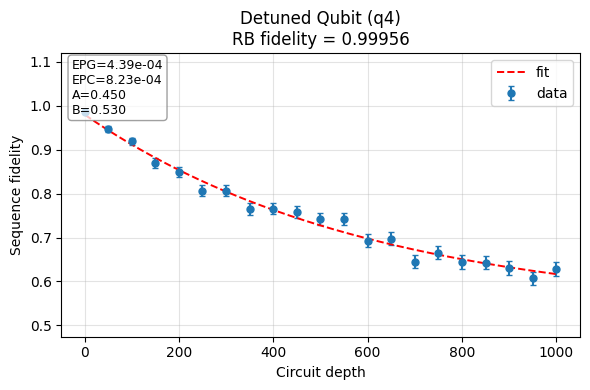

Detuned Qubit RB Fit:
A   = 0.45017
p   = 0.99835
B   = 0.52994
EPC = 8.230e-04
EPG = 4.389e-04
RB fidelity (Qolab) = 0.99956


In [7]:
# ---------------- Load dataset 120----------------
a = load_dataset(120)
depths = a[0]["depths"].values.astype(int)

# Dataset 118 is only for qubit 4 → index 0
state = a[0]["state"].values  # shape: (1, n_seeds, n_depths)

# ---------------- RB model ----------------
def rb_model(m, A, p, B):
    return A * (p ** m) + B

avg_gates_per_clifford = 1.875   # QOLab 1-qubit RB convention

# ---------------- Extract fidelity data ----------------
F_seeds = 1 - state[0]          # (n_seeds, n_depths)
F_mean  = F_seeds.mean(axis=0)
F_sem   = F_seeds.std(axis=0, ddof=1) / np.sqrt(F_seeds.shape[0])

# ---------------- Fit initial guesses ----------------
A0 = max(F_mean[0] - F_mean[-1], 1e-4)
B0 = F_mean[-1]
p0 = 0.99

try:
    popt, _ = curve_fit(rb_model, depths, F_mean, p0=[A0, p0, B0])
    A, p, B = popt
except Exception as e:
    print("Fit failed:", e)
    A, p, B = np.nan, np.nan, np.nan

# ---------------- Compute EPC, EPG, RB fidelity ----------------
EPC = (1 - p) / 2
EPG = EPC / avg_gates_per_clifford
RB_fidelity_qolab = 1 - EPG

# ---------------- Plot ----------------
plt.figure(figsize=(6,4))

plt.errorbar(depths, F_mean, yerr=F_sem, fmt='o', ms=5, capsize=2,
             color='#1f77b4', label='data')

m_smooth = np.linspace(depths.min(), depths.max(), 300)
plt.plot(m_smooth, rb_model(m_smooth, A, p, B), '--', lw=1.4, color='red', label='fit')

plt.title(f"Detuned Qubit (q4)\nRB fidelity = {RB_fidelity_qolab:.5f}", fontsize=12)
plt.xlabel("Circuit depth")
plt.ylabel("Sequence fidelity")
plt.grid(alpha=0.35)

# Smart y-limits
fmin, fmax = F_mean.min(), F_mean.max()
pad = 0.35 * max(fmax - fmin, 0.02)
plt.ylim(fmin - pad, fmax + pad)

# Text box with parameters
plt.text(
    0.02, 0.98,
    f"EPG={EPG:.2e}\nEPC={EPC:.2e}\nA={A:.3f}\nB={B:.3f}",
    transform=plt.gca().transAxes,
    ha='left', va='top',
    fontsize=9,
    bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.75)
)

plt.legend()
plt.tight_layout()
plt.show()

# ---------------- Print results ----------------
print("Detuned Qubit RB Fit:")
print(f"A   = {A:.5f}")
print(f"p   = {p:.5f}")
print(f"B   = {B:.5f}")
print(f"EPC = {EPC:.3e}")
print(f"EPG = {EPG:.3e}")
print(f"RB fidelity (Qolab) = {RB_fidelity_qolab:.5f}")

## Part (e) 
Update your config/quam state/state.json file to the qolab-start default
(by using git checkout or downloading it from github directly). Run node 10a -
Single Qubit Randomized Benchmarkin for only qubit 4 (by entering ‘q4’ in the
qubits box and clicking ‘Run’). What is resulting error? Is this better or worse
than the average error seen from the retuned RB from part (d)? At this point, your
config/quam state/state.json should be set back to the qolab provided defaults.
Unless you have strong reasons, this should always be the case. Dataset 113 may be
useful as reference.

### Answer (e):
For this last part of the problem, we are asked to restore the state.json file to use the current calibration of the qubits, but since we cannot obtain information from the experiments, I will use the data obtained from dataset #113 as a reference.                                                                                                         
If the calibration of the state of dataset #113 is equal to the current calibration, then the EPG = 0.00077 ≈ 0.077% (this is the value of dataset #113). And comparing this value from dataset #113 with EPG ≈ 0.077% with that from dataset #112 with EPG ≈0.173%, it is possible to see that the error with the default values of the state.json file (dataset #113) is even smaller than that obtained in part (d).                                                         
Down below I attached the plots of experiments #113 and #112 so you can notice the fidelity difference.

![alt text](image-2.png)

![alt text](image-3.png)


### Update (e):
Since the current amplitude value for the x180_DragCosine operation used in the "current" state.json file from Qolab, then we know from part (d) that with this configuration we obtain the lowest error per gate for qubit 4, which is approximately 0.04%.

# 5. Exploring Qualibrate Nodes
Within the data folder, I have in-
cluded several datasets for almost all pre-loaded nodes, including ones we ran and
discussed in class and ones that we have not. Pick one dataset that is not RB, Power
Rabi, T1, or IQ blobs (that is perhaps relevant to your final project). What does that
node do, from a qubit tune-up perspective? Look at the data and make observations.
Look at the source code for the experiment and make observations.


## Answers:
I chose to analyze node 06_Ramsey (dataset #90). This node implements a Ramsey sequence x90 - τ - x90 with virtual Z rotations that are equivalent to controlled detuning, which generates phase oscillations. One of the most relevant input parameters is the frequency detuning, which is found in the experiment's source code as frequency_detuning_in_mhz, since it sets the virtual detuning used for the phase shift of the second x90 gate.                                     
The experiment, by adjusting the damped oscillations, extracts the frequency offset (freq_offset) and the phase decoherence time T2* (decay), then updates the intermediate frequency (intermediate_frequency) of the qubit and proceeds to save the Ramsey decay in the state.                                                                         
Below, we can observe clear oscillations with different decay rates for each qubit, indicating different T2* values. We can see that qubits with faster decay have poorer phase coherence, which worsens the fidelity of long sequences and contributes to a higher error rate in gates.

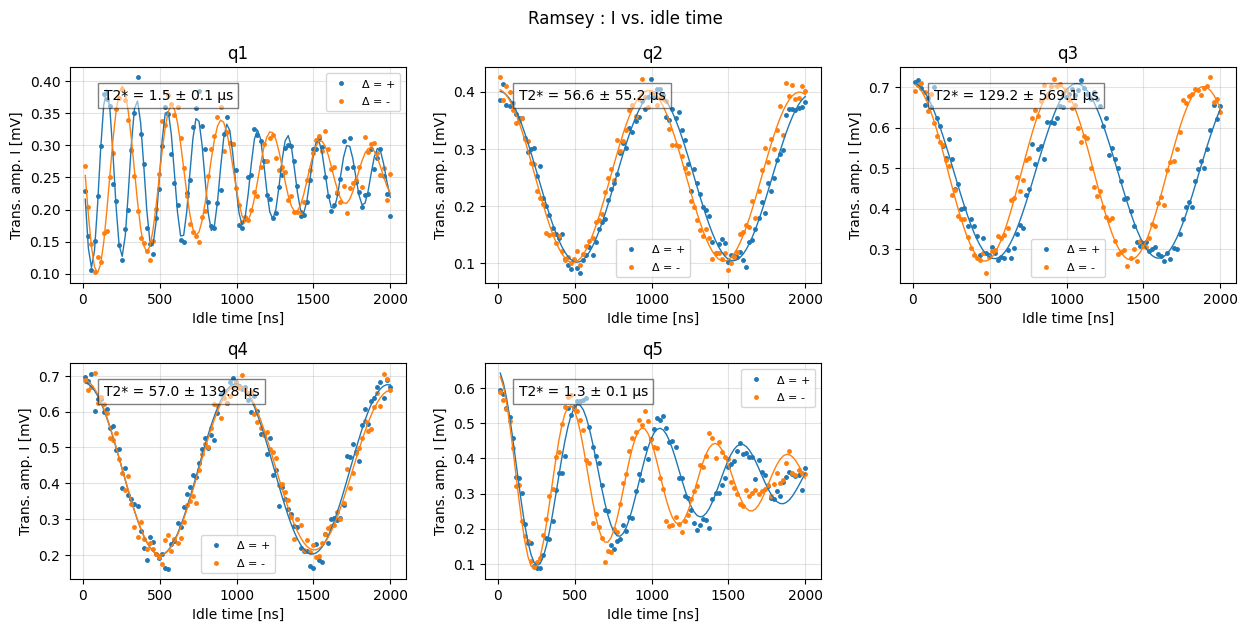

In [8]:
# ---------------- Load dataset 90 ----------------
b  = load_dataset(90)
ds = b[0]                       # xarray Dataset

# ---------------- Infer coordinate / variable names ----------------
# qubit coord
qubit_coord = None
for c in ds.coords:
    if c.lower() in ["qubit", "qubits", "q", "qubit_id", "qubit_name"]:
        qubit_coord = c
        break
if qubit_coord is None:
    raise ValueError(f"Couldn't infer qubit coordinate. Coords are: {list(ds.coords)}")

qubits = list(ds.coords[qubit_coord].values)
n_qubits = len(qubits)

# time coord (ns)
time_coord = None
for c in ds.coords:
    if c.lower() in ["time", "tau", "idle_time", "wait", "delay"]:
        time_coord = c
        break
if time_coord is None:
    raise ValueError(f"Couldn't infer time coord. Coords are: {list(ds.coords)}")

t_ns = ds[time_coord].values.astype(float)

# variable (node uses state if discrimination, else I)
use_state_disc = "state" in ds.data_vars
y_var = "state" if use_state_disc else "I"


# ---------------- Node-style Ramsey model ----------------
# t in ns, f in MHz, decay_rate in 1/ns
def ramsey_model_node(t_ns, A, decay_rate, f_mhz, phi, C):
    # cos argument must use t_us if f in MHz -> t_ns/1000 = us
    return A * np.exp(-decay_rate * t_ns) * np.cos(2*np.pi*f_mhz*(t_ns/1000.0) + phi) + C

def fit_ramsey_node_style(t_ns, y):
    # ---- initial guesses ----
    C0 = np.mean(y)
    A0 = 0.5*(np.max(y) - np.min(y))

    # FFT guess for f in MHz
    t_us = t_ns/1000.0
    dt_us = np.median(np.diff(t_us))
    freqs_mhz = np.fft.rfftfreq(len(t_us), dt_us)
    Y = np.abs(np.fft.rfft(y - C0))
    f0 = freqs_mhz[np.argmax(Y[1:]) + 1] if len(freqs_mhz) > 1 else 1.0

    # decay_rate guess: 1/(50 us) in 1/ns
    decay_rate0 = 1.0 / (50_000.0)   # 50 us = 50,000 ns

    p0 = [A0, decay_rate0, f0, 0.0, C0]

    # bounds: decay_rate between 1/(200 us) and 1/(0.05 us)
    bounds = (
        [-np.inf, 1.0/(200_000.0), 0.0, -2*np.pi, -np.inf],
        [ np.inf, 1.0/(50.0),     np.inf, 2*np.pi,  np.inf]
    )

    popt, pcov = curve_fit(
        ramsey_model_node, t_ns, y,
        p0=p0, bounds=bounds, maxfev=20000
    )
    perr = np.sqrt(np.diag(pcov))
    return popt, perr


# ---------------- Multi-panel layout ----------------
cols = 3 if n_qubits > 3 else n_qubits
rows = math.ceil(n_qubits / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4.2*cols, 3.2*rows), squeeze=False)

for qi, q in enumerate(qubits):
    ax = axes[qi // cols][qi % cols]

    dqi = ds.sel({qubit_coord: q})

    # Δ = + and Δ = - traces
    if use_state_disc:
        y_plus  = dqi.sel(sign= 1)[y_var].values
        y_minus = dqi.sel(sign=-1)[y_var].values
        ylabel = "State"
        scale = 1.0
    else:
        y_plus  = (dqi.sel(sign= 1)[y_var].values) * 1e3  # mV
        y_minus = (dqi.sel(sign=-1)[y_var].values) * 1e3
        ylabel = "Trans. amp. I [mV]"
        scale = 1e3

    ax.plot(t_ns, y_plus,  ".", ms=5, color="C0", label=r"$\Delta$ = +")
    ax.plot(t_ns, y_minus, ".", ms=5, color="C1", label=r"$\Delta$ = -")

    # ---- Fit each sign + overlay (node-style) ----
    try:
        popt_p, perr_p = fit_ramsey_node_style(t_ns, y_plus)
        popt_m, perr_m = fit_ramsey_node_style(t_ns, y_minus)

        yfit_p = ramsey_model_node(t_ns, *popt_p)
        yfit_m = ramsey_model_node(t_ns, *popt_m)

        ax.plot(t_ns, yfit_p, "-", lw=1, color="C0")
        ax.plot(t_ns, yfit_m, "-", lw=1, color="C1")

        # decay_rate -> T2* (ns), then to µs
        decay_rate_p, decay_rate_m = popt_p[1], popt_m[1]
        T2_ns_p, T2_ns_m = 1.0/decay_rate_p, 1.0/decay_rate_m
        T2_ns_avg = 0.5*(T2_ns_p + T2_ns_m)

        # error propagation for 1/decay_rate
        e_rate_p, e_rate_m = perr_p[1], perr_m[1]
        e_T2_p = e_rate_p/(decay_rate_p**2)
        e_T2_m = e_rate_m/(decay_rate_m**2)
        e_T2_avg = 0.5*np.sqrt(e_T2_p**2 + e_T2_m**2)

        T2_us_avg  = T2_ns_avg/1000.0
        eT2_us_avg = e_T2_avg/1000.0

        ax.text(
            0.1, 0.9,
            f"T2* = {T2_us_avg:.1f} ± {eT2_us_avg:.1f} µs",
            transform=ax.transAxes,
            fontsize=10, va="top",
            bbox=dict(facecolor="white", alpha=0.5),
        )

    except Exception as e:
        print(f"Fit failed for {q}: {e}")

    # labels/titles exactly like node
    ax.set_xlabel("Idle time [ns]")
    ax.set_ylabel(ylabel)
    ax.set_title(str(q))
    ax.grid(alpha=0.35)
    ax.legend(fontsize=8)

# Hide unused panels
for i in range(n_qubits, rows*cols):
    axes[i // cols][i % cols].axis('off')

fig.suptitle("Ramsey : I vs. idle time")
plt.tight_layout()
plt.show()


## Conclusions:
After plotting the graph for each qubit, we can notice that the Ramsey node is used to measure dephasing time T2* from the exponential decay envolope. It also measures the frequency mis-calibration from the oscilation frequency. And as it was etablished before, the experiment updates the qubit's intermediate frequency based on the extracted frequency offset.


## Observations from the Data:
First, it can be noticed that all 5 qubits show and oscillatory behavior, confirming a detuning between the qubit frame and applied drive.                                                                                                
Also, thanks to the graph, it is possible to see that the envelope decay varies between qubits. For example, qubits 1 and 5, which have a T2* ∼1–2 μs, their fringes vanish quickly, indicating poor phase coherence and strong low-frequency noise.                                                                                                    
In contrast, qubits 2 and 4, with T2* ∼ 50–60 μs, show much better phase shift performance and maintain phase coherence during long idle times.                                                                                       
Additionally, it can be noted that qubit 3 has a large uncertainty in the adjustment, suggesting greater instability.   
Finally, the two detuning signs (Δ = + and Δ = −) are nearly mirror-symmetric for most qubits. That’s expected: flipping detuning flips the phase evolution direction but not the decay envelope.

## Observation from the Source Code:
Based on the implementation of the node, we can confirm that the experiment sweeps downtime and applies virtual detuning through the second pulse phase. Measuring decay and frequency offset to update the calibration frequency.